In [70]:
#Importar librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

#Importamos modelos clasificatorios
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [71]:
#Antes de comenzar a trabajar con los datos, generaremos datos aleatorios para simular un conjunto de datos reales.
#Generar un DataFrame con datos aleatorios, para simular datos erroneos y faltantes en un conjunto de datos reales.
data = {
    "PassengerId": range(1, 419),
    "Survived": np.random.choice([0, 1], size=418),
    "Pclass": np.random.choice([1, 2, 3], size=418),
    "Name": [f"Passenger {i}" for i in range(1, 419)],
    "Sex": np.random.choice(["male", "female"], size=418),
    "Age": np.random.uniform(1, 80, size=418),
    "SibSp": np.random.randint(0, 5, size=418),
    "Parch": np.random.randint(0, 5, size=418),
    "Ticket": [f"T{i:04d}" for i in range(1, 419)],
    "Fare": np.random.uniform(5, 500, size=418),
    "Cabin": np.random.choice([None, "C123", "B45", "D36"], size=418, p=[0.7, 0.1, 0.1, 0.1]),
    "Embarked": np.random.choice(["C", "Q", "S"], size=418)
}

df_dirty = pd.DataFrame(data)

# Introducir datos faltantes
df_dirty.loc[np.random.choice(df_dirty.index, size=20, replace=False), "Age"] = np.nan
df_dirty.loc[np.random.choice(df_dirty.index, size=5, replace=False), "Fare"] = np.nan
df_dirty.loc[np.random.choice(df_dirty.index, size=30, replace=False), "Cabin"] = np.nan

# Introducir valores atípicos en las columnas numéricas
df_dirty.loc[np.random.choice(df_dirty.index, size=5, replace=False), "Age"] = 150  # Edad fuera de rango
df_dirty.loc[np.random.choice(df_dirty.index, size=3, replace=False), "Fare"] = -50  # Tarifas negativas

# Introducir datos erróneos en las columnas categóricas
df_dirty.loc[np.random.choice(df_dirty.index, size=5, replace=False), "Sex"] = "unknown"
df_dirty.loc[np.random.choice(df_dirty.index, size=5, replace=False), "Embarked"] = "X"

# Introducir errores en el formato del Ticket
df_dirty.loc[np.random.choice(df_dirty.index, size=5, replace=False), "Ticket"] = None
df_dirty.loc[np.random.choice(df_dirty.index, size=5, replace=False), "Ticket"] = "INVALID"

# Mostrar un resumen del DataFrame modificado
print(df_dirty.info())
print(df_dirty.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          398 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       413 non-null    object 
 9   Fare         413 non-null    float64
 10  Cabin        126 non-null    object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB
None
   PassengerId  Survived  Pclass         Name     Sex        Age  SibSp  \
0            1         0       1  Passenger 1    male  51.067198      1   
1            2         0       2  Passenger 2    male  37.707270      1   
2            3

#### 1. Carga y estudio de la estructura del dataset

In [72]:
data = pd.read_csv(r'./datasets/data.csv')

#Mostramos la catidad de filas y columnas
print("Cantidad de filas y columnas: ")
print(data.shape)

#Mostramos los tipos de datos de las columnas
print("Tipos de datos de las columnas: ")
print(data.dtypes)
print("\n") 


#Contatenamos los dos dataframes
data = pd.concat([data, df_dirty])

#Mostramos información relevante del dataset
print("-------------------------------")
print("Datos dataset una vez modificado con el dataset con datos erroneos")

#Mostramos la catidad de filas y columnas
print("Cantidad de filas y columnas: ")
print(data.shape)

#Mostramos los tipos de datos de las columnas
print("Tipos de datos de las columnas: ")
print(data.dtypes)
print("\n") 

print("Resumen de las columnas: ")
print(data.info())
print("\n") 

#Mostramos los primeros 5 registros
print("Primeros 5 registros: ")
print(data.head())
print("\n") 

#Mostramos los valores nulos
print("Valores nulos: ")
print(data.describe())


#Guardamos la columna de la variable objetivo
target_classification = 'Survived'


Cantidad de filas y columnas: 
(418, 12)
Tipos de datos de las columnas: 
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


-------------------------------
Datos dataset una vez modificado con el dataset con datos erroneos
Cantidad de filas y columnas: 
(836, 12)
Tipos de datos de las columnas: 
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Resumen de las columnas: 
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
-

#### Limpieza de datos
- Deteccion de valores atipicos en el dataset:
    1. Deteccion de valores nulos
    2. Deteccion de valores erroneos
    3. Deteccion de valores faltantes
    4. Deteccion de valores atipicos mediante graficas (columnas numericas)

In [73]:
#Deteccion de valores nulos por columna
total_wrong_values = 0
null_values = data.isnull().sum()
print("Valores nulos por columna: ")
print(null_values)

na_values = data.isna().sum().sort_values(ascending=False)
print("Cantidad de valores NA por columna")
print(na_values)

#Mostramos los valores unicos de cada columnas categoricas
print("Valores unicos de cada columna categoricas")
for column in data.select_dtypes(include='object').columns:
    print(column, data[column].unique())

rows_wrong_name = data[data['Name'].str.contains('Passenger')].shape[0]
print(f"Filas con nombres incorrectos: {rows_wrong_name}")

rows_wrong_gender = data[data['Sex'] == 'unknown'].shape[0]
print(f"Filas con género incorrecto: {rows_wrong_gender}")

rows_wrong_ticket = data[data['Ticket'] == 'INVALID'].shape[0]
print(f"Filas con ticket incorrecto: {rows_wrong_ticket}")

rows_wrong_fare = data[data['Fare'] < 0].shape[0]
print(f"Filas con tarifa incorrecta: {rows_wrong_fare}")

total_rows = data.shape[0]
total_wrong_values = (null_values.sum() + rows_wrong_name + rows_wrong_gender + rows_wrong_ticket + rows_wrong_fare * 100) / total_rows 
print(f"Porcentaje de valores incorrectos: {total_wrong_values:.2f}%")



Valores nulos por columna: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            106
SibSp            0
Parch            0
Ticket           5
Fare             6
Cabin          619
Embarked         0
dtype: int64
Cantidad de valores NA por columna
Cabin          619
Age            106
Fare             6
Ticket           5
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Embarked         0
dtype: int64
Valores unicos de cada columna categoricas
Name ['Kelly, Mr. James' 'Wilkes, Mrs. James (Ellen Needs)'
 'Myles, Mr. Thomas Francis' 'Wirz, Mr. Albert'
 'Hirvonen, Mrs. Alexander (Helga E Lindqvist)'
 'Svensson, Mr. Johan Cervin' 'Connolly, Miss. Kate'
 'Caldwell, Mr. Albert Francis'
 'Abrahim, Mrs. Joseph (Sophie Halaut Easu)' 'Davies, Mr. John Samuel'
 'Ilieff, Mr. Ylio' 'Jones, Mr. Charles Cresson'
 'Snyder, Mrs. John Pillsbury (Nelle Stevenson)' 'H

In [74]:
#Eliminamos las filas con valores incorrectos
print(data.shape)
#Corroboramos que se hayan eliminado los valores nulos
null_values = data.isnull().sum().sort_values(ascending=False)
print("Cantidad de valores nulos por columna")
print(null_values)
# Eliminamos datos con NaN en sus valores en este caso en las columnas Fare y Ticker
data_clean = data.dropna(subset=['Fare', 'Ticket'])


data_clean = data_clean[data_clean['Name'].str.contains('Passenger') == False]
data_clean = data_clean[data_clean['Sex'] != 'unknown']
data_clean = data_clean[data_clean['Ticket'] != 'INVALID']
data_clean = data_clean[data_clean['Fare'] > 0]

#Imputamos el valor promedio a los registros que no tienen Edad Definida
# Imputar con la mediana
from sklearn.impute import SimpleImputer
imputer_age = SimpleImputer(strategy='median')
data_clean['Age'] = imputer_age.fit_transform(data_clean[['Age']])

data['Cabin'] = data['Cabin'].fillna('Missing')

# Corroboramos que se hayan eliminado los valores erroneos
rows_wrong_name = data_clean[data_clean['Name'].str.contains('Passenger')].shape[0]
print(f"Filas con nombres incorrectos: {rows_wrong_name}")

rows_wrong_gender = data_clean[data_clean['Sex'] == 'unknown'].shape[0]
print(f"Filas con género incorrecto: {rows_wrong_gender}")

rows_wrong_ticket = data_clean[data_clean['Ticket'] == 'INVALID'].shape[0]
print(f"Filas con ticket incorrecto: {rows_wrong_ticket}")

rows_wrong_fare = data_clean[data_clean['Fare'] < 0].shape[0]
print(f"Filas con tarifa incorrecta: {rows_wrong_fare}")
print(data_clean.shape)
#Corroboramos que se hayan eliminado los valores nulos
null_values = data.isnull().sum().sort_values(ascending=False)
print("Cantidad de valores nulos por columna")
print(null_values)

(836, 12)
Cantidad de valores nulos por columna
Cabin          619
Age            106
Fare             6
Ticket           5
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Embarked         0
dtype: int64
Filas con nombres incorrectos: 0
Filas con género incorrecto: 0
Filas con ticket incorrecto: 0
Filas con tarifa incorrecta: 0
(415, 12)
Cantidad de valores nulos por columna
Age            106
Fare             6
Ticket           5
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Cabin            0
Embarked         0
dtype: int64


Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


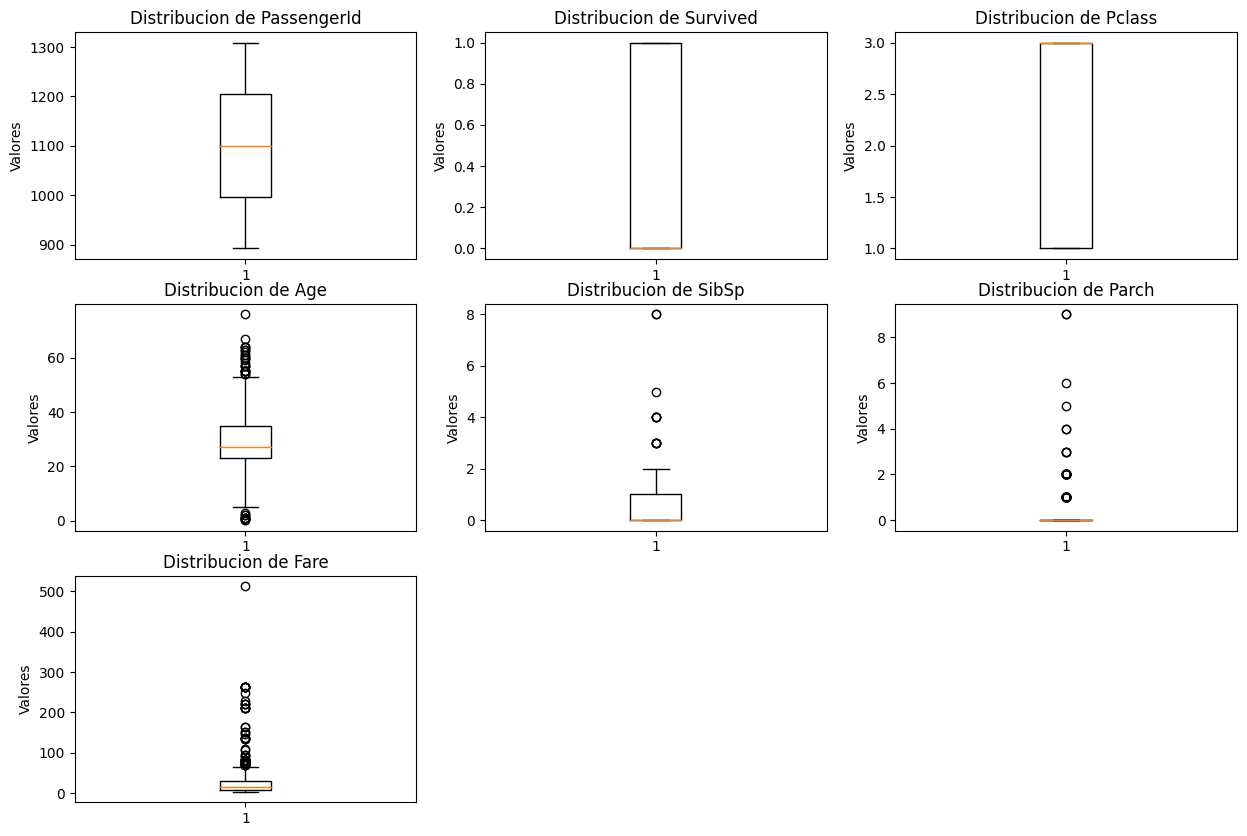

In [75]:
categories = data_clean.select_dtypes(include='number').columns
print(categories)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

#Graficamos la distribucion de las variables numericas
for i, var in enumerate(categories):
    axes[i].boxplot(data_clean[var])
    axes[i].set_title(f"Distribucion de {var}")
    axes[i].set_ylabel("Valores")

for j in range(len(categories), len(axes)):
    axes[j].axis('off')

plt.show()

🤔 Antes de continuar verificamos si el dataframe esta desbalanceado

In [76]:
class_types = data_clean[target_classification].value_counts()
class_proportion = data_clean[target_classification].value_counts(normalize=True) * 100

print("Tipos de clases")
print(class_types)
print("Proporcion de clases")
print(round(class_proportion,2))

Tipos de clases
Survived
0    263
1    152
Name: count, dtype: int64
Proporcion de clases
Survived
0    63.37
1    36.63
Name: proportion, dtype: float64


Ingenieria de caracteristicas

In [77]:
#Convertir la columna age a tipo entero
data_clean['Age'] = data_clean['Age'].astype(int)

# Convertir todas las columnas categóricas object a tipo category
data_clean[data_clean.select_dtypes(['object']).columns] = data_clean.select_dtypes(['object']).astype('category')
print(data_clean.info())

#Codificamos las columnas categoricas
gender_map = {'male': 0, 'female': 1}
data_clean['gender_encoded'] = data_clean['Sex'].map(gender_map)

#Codificamos la columna embarked con one-hot encoding
data_embarked = pd.get_dummies(data_clean['Embarked'], prefix='Embarked', dtype=int, drop_first=True)
data_clean = pd.concat([data_clean, data_embarked], axis=1)

#Eliminamos columnas no numericas
data_encoded = data_clean.drop(['Name','Sex','Ticket','Cabin','Embarked'], axis=1)

#Verificamos que todas las columnas sean numericas
print("Verificamos que todas las columnas sean numericas")
print(data_encoded.info())
print(data_encoded.head())



<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  415 non-null    int64   
 1   Survived     415 non-null    int64   
 2   Pclass       415 non-null    int64   
 3   Name         415 non-null    category
 4   Sex          415 non-null    category
 5   Age          415 non-null    int64   
 6   SibSp        415 non-null    int64   
 7   Parch        415 non-null    int64   
 8   Ticket       415 non-null    category
 9   Fare         415 non-null    float64 
 10  Cabin        90 non-null     category
 11  Embarked     415 non-null    category
dtypes: category(5), float64(1), int64(6)
memory usage: 62.0 KB
None
Verificamos que todas las columnas sean numericas
<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, 0 to 417
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          ------------

### Seleccion de caracteristicas
En esta seccion vamos a elegir las columnas que son mas relevantes con el valor target, creando un mapa de correlacion
Este mapa nos mostrará de forma gráfica las dependencias entre las diferentes
variables
- Una correlación alta (cercana a 1) entre dos variables indicará que cuando una aumenta la otra también lo hace
- También tenemos que tener en cuenta la correlación inversa(cercana a -1) cuando una aumenta la otra desciende

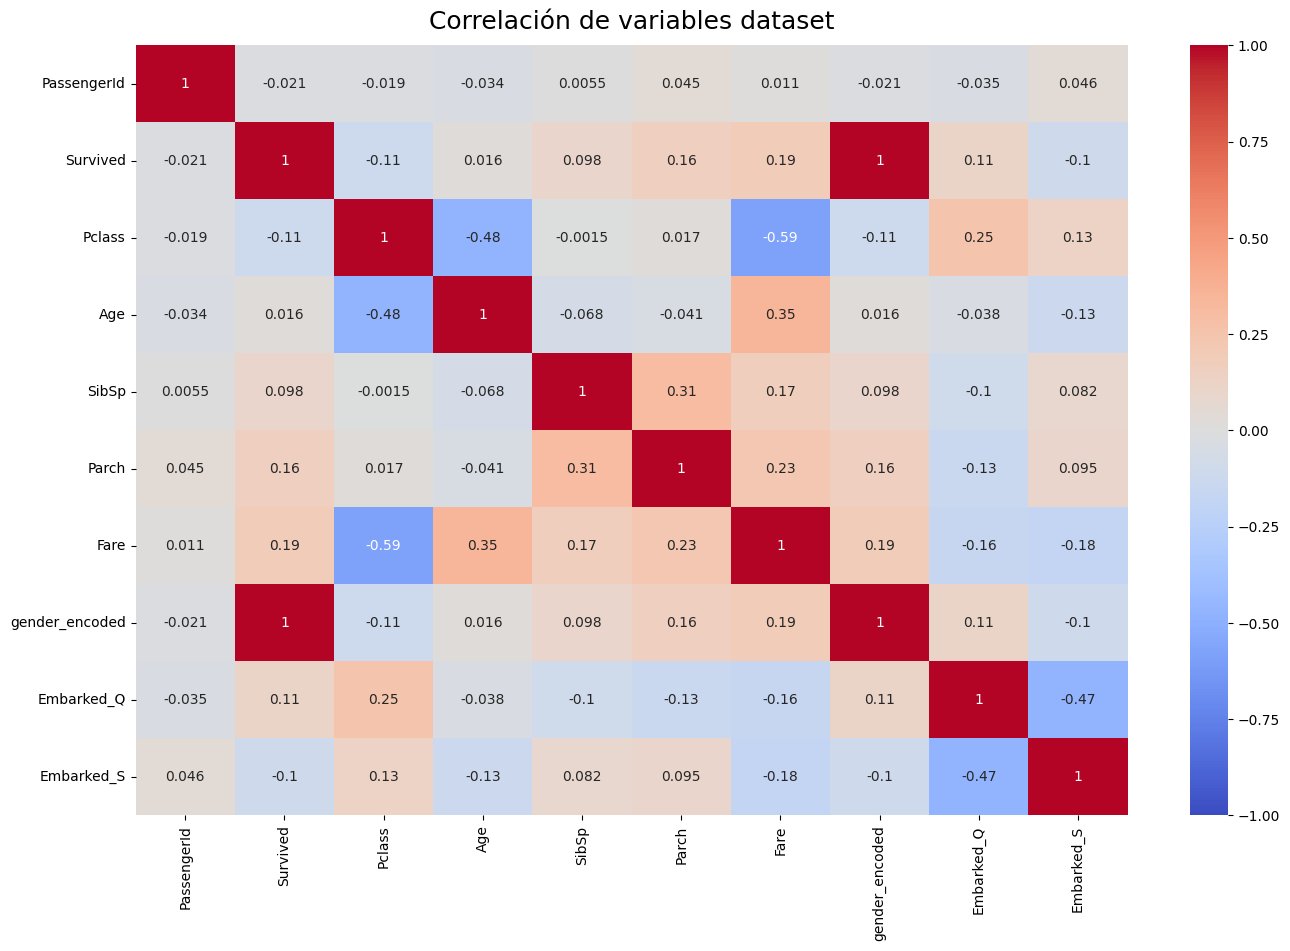

In [78]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(data_encoded.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlación de variables dataset', fontdict={'fontsize': 18}, pad=12)
plt.show()

Una vez observado el grafico, hacemos una seleccion de las columnas mas relevantes con nuestro target o valor predictor, en este caso seleccionaremos las siguientes columnas
1. Pclass
2. Parch
3. Fare
4. gender_encoded
5. Embarked_S


In [79]:
relevant_columns_classification = ['Pclass', 'Parch', 'Fare', 'gender_encoded', 'Embarked_S']
data_encoded = data_encoded[relevant_columns_classification + [target_classification]]

print("Columnas relevantes")
print(data_encoded.head())
print(data_encoded.info())

#Escalamos las variables numericas
scaler = StandardScaler()
data_encoded[['Pclass', 'Parch', 'Fare', 'gender_encoded', 'Embarked_S']] = scaler.fit_transform(data_encoded[['Pclass', 'Parch', 'Fare', 'gender_encoded', 'Embarked_S']])

print("Columnas escaladas")
print(data_encoded.head())



Columnas relevantes
   Pclass  Parch     Fare gender_encoded  Embarked_S  Survived
0       3      0   7.8292              0           0         0
1       3      0   7.0000              1           1         1
2       2      0   9.6875              0           0         0
3       3      0   8.6625              0           1         0
4       3      1  12.2875              1           1         1
<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, 0 to 417
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Pclass          415 non-null    int64   
 1   Parch           415 non-null    int64   
 2   Fare            415 non-null    float64 
 3   gender_encoded  415 non-null    category
 4   Embarked_S      415 non-null    int64   
 5   Survived        415 non-null    int64   
dtypes: category(1), float64(1), int64(4)
memory usage: 20.0 KB
None
Columnas escaladas
     Pclass     Parch      Fare  gender_encoded

#### Entrenamiento de Modelos de Clasificación
1. Logistic Regresion
2. Random Forest
3. XGBoost

In [80]:
# Creamos una funcion que entrene un modelo de clasificacion y muestre las metricas y la matriz de confusion
def train_model(model, type_model):
    model.fit(X_resampled, y_resampled.astype(int))
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_pred, y_test.astype(int))

    print("Metricas del modelo: ", type_model)
    print(classification_report(y_pred, y_test.astype(int)))
    print("Score Test: ", model.score(X_test, y_test.astype(int)))
    print("Score Train: ", model.score(X_resampled, y_resampled.astype(int)))

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedida', 'Concedidas'], yticklabels=['No Concedida', 'Concedidas'])
    plt.xlabel('Prediccion')
    plt.ylabel('Real')
    plt.title('Matriz de confusion del modelo ' + type_model)
    plt.show()

Distribución original de clases:
Survived
0    263
1    152
Name: count, dtype: int64

Distribución de clases después de SMOTE:
Survived
1    204
0    204
Name: count, dtype: int64
Metricas del modelo:  Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        24

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Score Test:  1.0
Score Train:  1.0


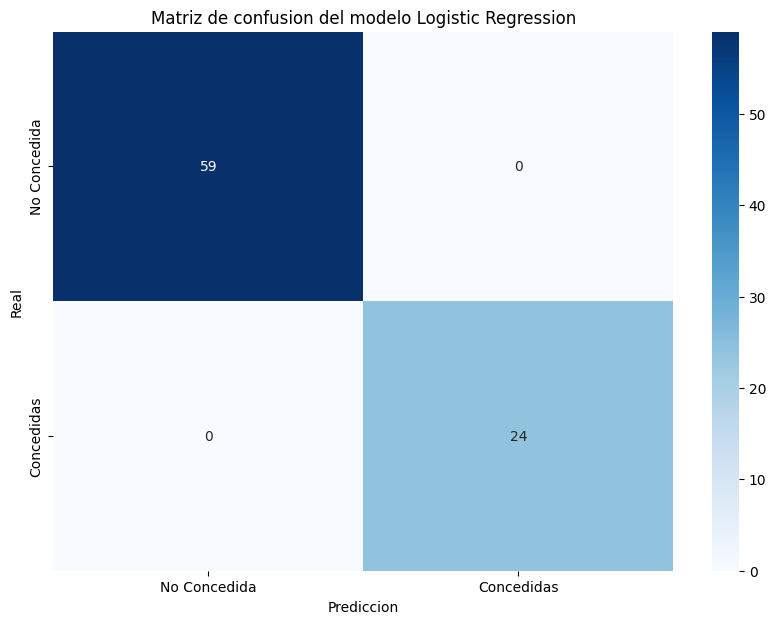

Metricas del modelo:  Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        24

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Score Test:  1.0
Score Train:  1.0


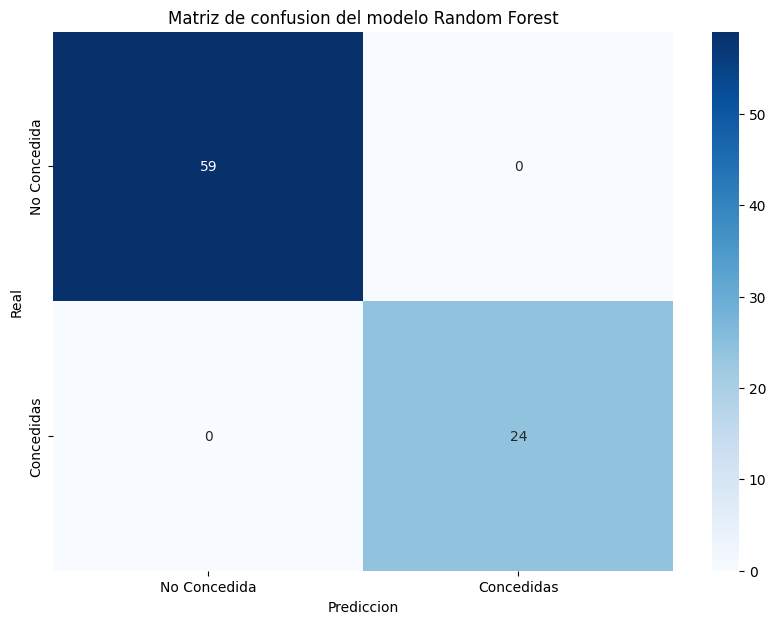

Metricas del modelo:  Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        24

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Score Test:  1.0
Score Train:  1.0


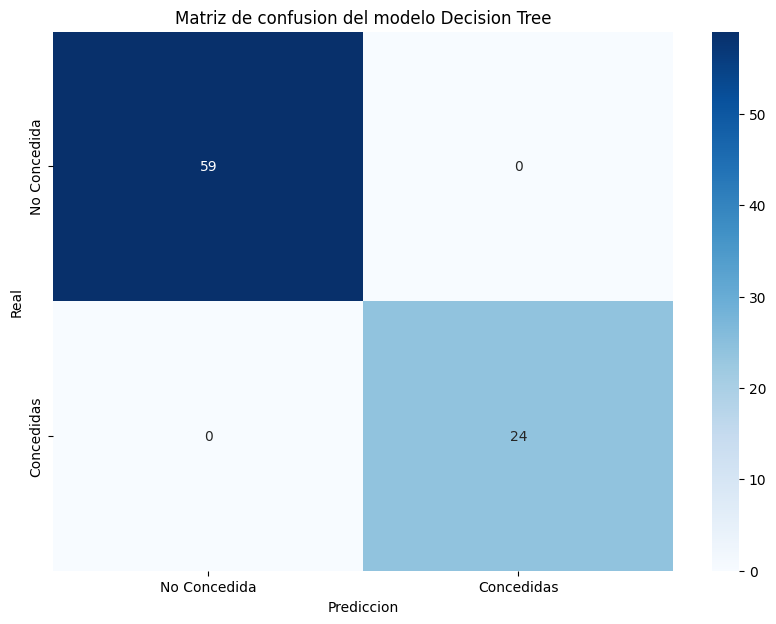

Metricas del modelo:  SVM
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.96      1.00      0.98        23

    accuracy                           0.99        83
   macro avg       0.98      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83

Score Test:  0.9879518072289156
Score Train:  1.0


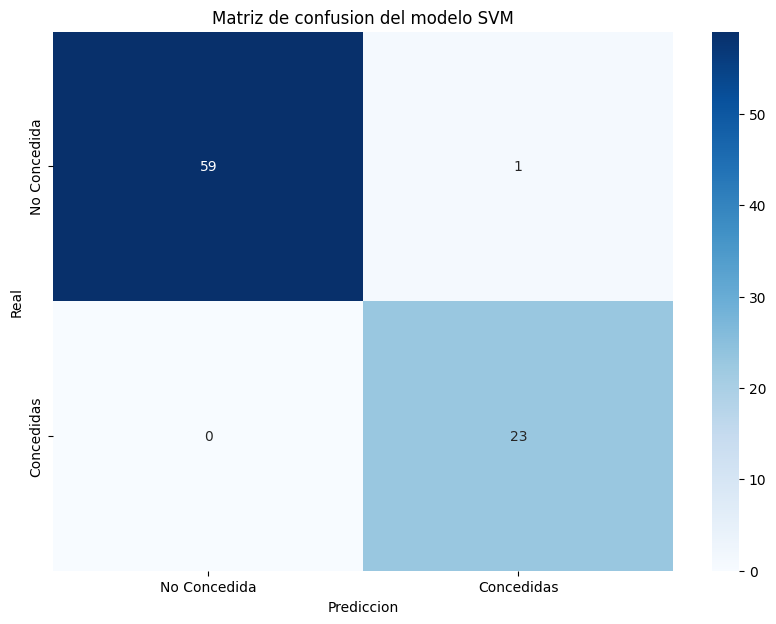

Metricas del modelo:  XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        24

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Score Test:  1.0
Score Train:  1.0


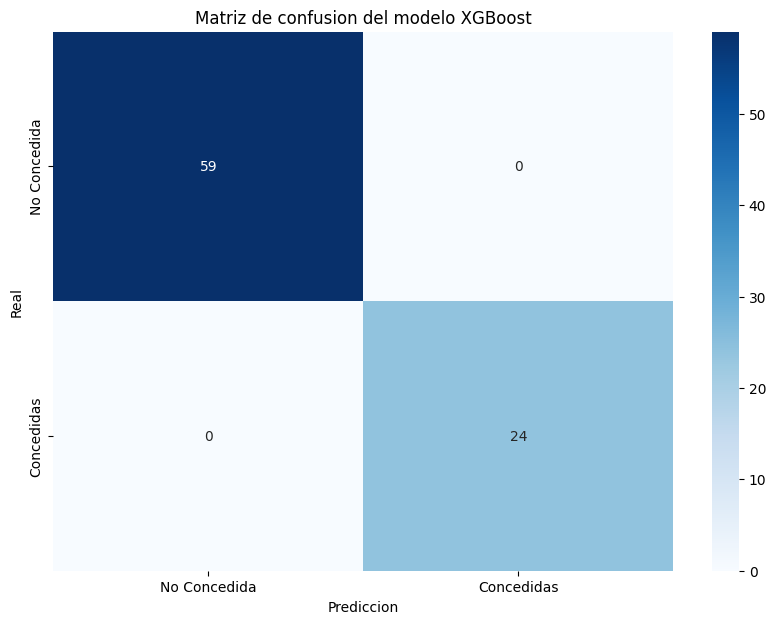

In [81]:
#Separamos las columnas predictoras y la variable target
X = data_encoded.drop(columns=[target_classification])
y = data_encoded[target_classification]

# Verificar el balance de clases
print("Distribución original de clases:")
print(y.value_counts())

#Dividimos el dataset en conjunto de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Al contar con tan pocos datos tenemos que generar datos de forma sintetica
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verificar el balance después de SMOTE
print("\nDistribución de clases después de SMOTE:")
print(pd.Series(y_resampled).value_counts())

#Creamos el modelo y entrenamos
lr = LogisticRegression(random_state=42)
train_model(lr, 'Logistic Regression')

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
train_model(rf, 'Random Forest')

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
train_model(dt, 'Decision Tree')

svm= SVC(kernel = 'rbf',C=1.0, gamma='scale',probability=True)
train_model(svm, 'SVM')

xgb = XGBClassifier(max_depth=5)
train_model(xgb, 'XGBoost')

### 📊 Curva ROC
La curva ROC (Receiver Operating Characteristic) es otra metrica que nos ayuda a determinar como de bien se comporta el modelo distinguiendo entre las clases positivas y negativas y a su vez nos permite seleccionar el mejor modelo para el problema que estamos tratando (Cuanto mas se aproxime a 1 en la grafica mejor desepeño tendra el modelo clasificando los registros).

<Figure size 1000x800 with 0 Axes>

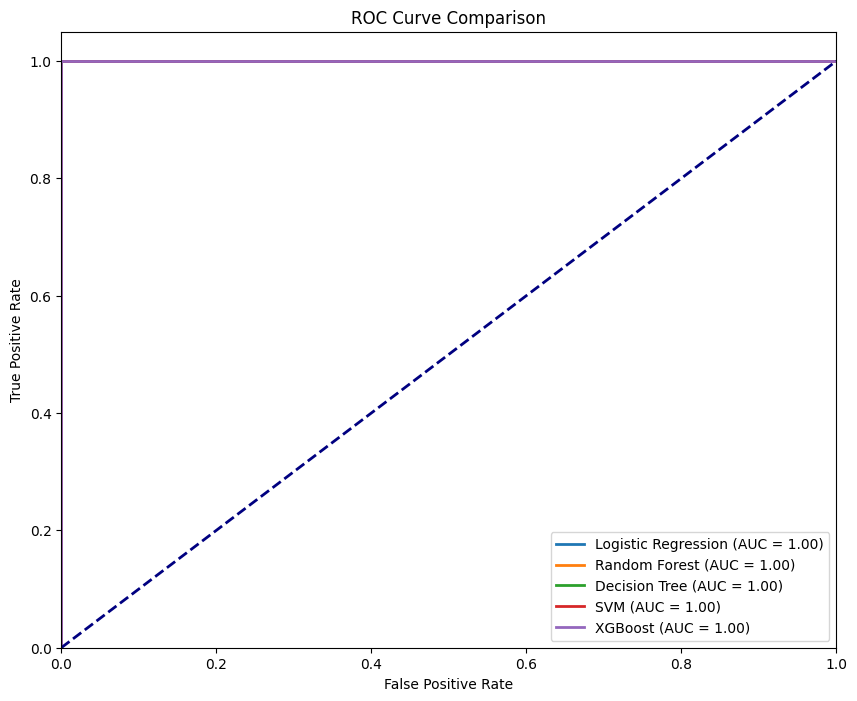

Logistic Regression: AUC - ROC = 1.00
Random Forest: AUC - ROC = 1.00
Decision Tree: AUC - ROC = 1.00
SVM: AUC - ROC = 1.00
XGBoost: AUC - ROC = 1.00


In [82]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
models = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'Decision Tree': dt,
    'SVM': svm,
    'XGBoost': xgb
}
plt.figure(figsize=(10, 8))

roc_auc_scores = {}

# Initialize a dictionary to store AUC - ROC scores
roc_auc_scores = {}

# Plot the ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict the probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate the AUC - ROC score
    roc_auc = roc_auc_score(y_test, y_probs)
    roc_auc_scores[name] = roc_auc
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Print the AUC - ROC scores for each model
for name, score in roc_auc_scores.items():
    print(f'{name}: AUC - ROC = {score:.2f}')

### Ajuste de hiperarametros 
Optimizamos los parametros del modelo XGBClassifier mediante optuna

In [84]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'binary:logistic',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # Create an XGBoost classifier with the suggested hyperparameters
    xgb = XGBClassifier(**params, random_state=42)

    xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    scores = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
    return scores.mean()

# Create an Optuna study with TPE sampler
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

# Oprimizacion del estudio para 100 epocas
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial}")
print(f"Best hyperparameters: {study.best_params}")
print(f"Best score: {study.best_value:.4f}")

[I 2025-01-20 11:56:30,073] A new study created in memory with name: no-name-41b01435-aea0-4cea-8e3e-0cbd3adc69b6
[I 2025-01-20 11:56:30,875] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 3, 'learning_rate': 0.28077950835176874, 'n_estimators': 149, 'subsample': 0.9715610970209612, 'colsample_bytree': 0.6719118318477348, 'gamma': 1.0476552770863246, 'min_child_weight': 4}. Best is trial 0 with value: 1.0.
[I 2025-01-20 11:56:31,374] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.017829558396538006, 'n_estimators': 136, 'subsample': 0.8015253795717179, 'colsample_bytree': 0.5341135310074816, 'gamma': 2.318882138208273, 'min_child_weight': 2}. Best is trial 0 with value: 1.0.
[I 2025-01-20 11:56:31,784] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.012694498261912825, 'n_estimators': 62, 'subsample': 0.5077909703085228, 'colsample_bytree': 0.5156886635335389, 'gamma': 2.8182055011687575, 'min_ch

Best trial: FrozenTrial(number=0, state=TrialState.COMPLETE, values=[1.0], datetime_start=datetime.datetime(2025, 1, 20, 11, 56, 30, 74753), datetime_complete=datetime.datetime(2025, 1, 20, 11, 56, 30, 874759), params={'max_depth': 3, 'learning_rate': 0.28077950835176874, 'n_estimators': 149, 'subsample': 0.9715610970209612, 'colsample_bytree': 0.6719118318477348, 'gamma': 1.0476552770863246, 'min_child_weight': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1)}, tr

Evaluamos el modelo optimizado con los mejores hiperparametros


/home/ricardo/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:04:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Metricas del modelo:  XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        24

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Score Test:  1.0
Score Train:  1.0


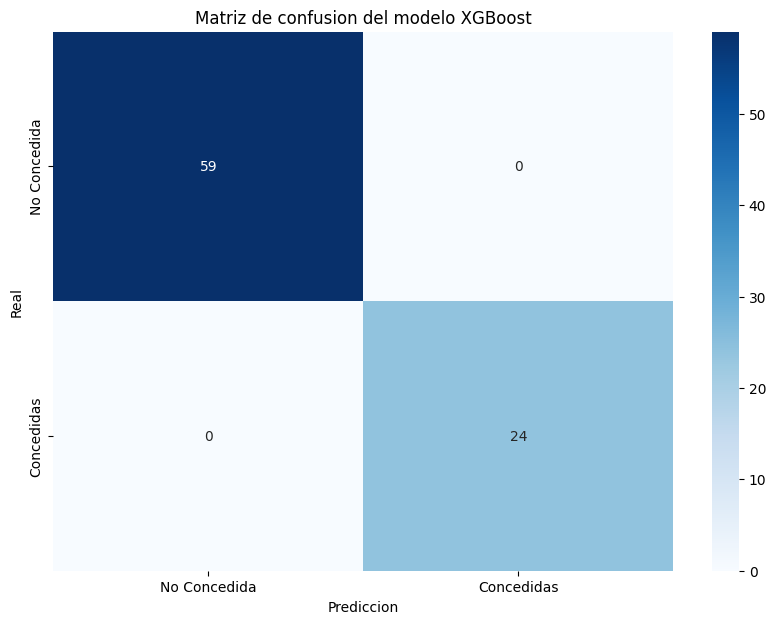

In [86]:
best_params = study.best_params
best_params['objective'] = 'binary:logistic'

xgb_final_model = XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
train_model(xgb_final_model, 'XGBoost')

In [88]:
#Clasificamos un nuevo registro con el modelo optimizado con optuna
relevant_columns_classification = ['Pclass', 'Parch', 'Fare', 'gender_encoded', 'Embarked_S']

new_passeger = {
    'Pclass': 1,
    'Parch': 0,
    'Fare': 82.2667,
    'gender_encoded': 1,
    'Embarked_S': 1    
}

new_passeger_third_class = {
    'Pclass': 3,
    'Parch': 0,
    'Fare': 24.15,
    'gender_encoded': 0,
    'Embarked_S': 1 
}

dt_new_record = pd.DataFrame([new_passeger])
dt_new_record_third = pd.DataFrame([new_passeger_third_class])

#Escalamos las variables
columns_to_scale = ['income', 'amount', 'int_rate', 'percent_income']
# Escalamos el nuevo registro
dt_new_record[relevant_columns_classification] = scaler.transform(dt_new_record[relevant_columns_classification])
dt_new_record_third[relevant_columns_classification] = scaler.transform(dt_new_record_third[relevant_columns_classification])



prediction = xgb_final_model.predict(dt_new_record)
print("Prediccion del modelo: ", prediction)

prediction = xgb_final_model.predict(dt_new_record_third)
print("Prediccion del modelo: ", prediction)

Prediccion del modelo:  [1]
Prediccion del modelo:  [0]


### 📝 Conclusiones modelo de clasificacion seleccionado
"Con el modelo seleccionado y los hiperparametros optimizados hemos llegado a la conclusion de que el pasajero nuevo que introducimos al dataset sobreviviria a la catastrofe"